# Seleção de Protótipos

***


## Índice

1. [Motivação](#motivação)
2. [Edited Nearest Neighbors](#edited-nearest-neighbors)
3. [Condensed Nearest Neighbors](#condensed-nearest-neighbors)
4. [Instance Hardness Threshold](#instance-hardness-threshold)

## Motivação

Seleção de protótipos refere-se ao ato de remover instâncias do _dataset_. A remoção controlada tem como objetivo melhorar o dataset inicial, criando uma região de separação mais clara entre as classes ou para resolver problemas inerentes dos classificadores. Vamos observar o _kNN_ como exemplo, podemos citar algumas falhas do algoritmo:

- computa a distância da instância de teste para todas as instâncias de treino, se a quantidade de amostras for muito grande, o algoritmo demora mais tempo
- ao observar a região de vizinhança de uma amostra que se encontra na região de separação de duas classes, não havendo uma clara predominância de uma das classes, qualquer variação pode levar a uma mudança na classificação, sendo menos resiliente à ruídos.

O problema do ruído pode ser mitigado por aumentar o valor de $k$, escolhido durante o processo de otimização do modelo. Entretanto, a melhor solução pode ser um valor pequeno de $k$, e é apenas necessária uma pequena melhora nos limites de decisão do algoritmo.

Para isso, utilizamos métodos de seleção de protótipo. Os algoritmos de seleção de protótipo não estão disponíveis no _sklearn_. Entretanto, existem bibliotecas que implementam esses algoritmos, como o [_imbalanced-learn_](https://imbalanced-learn.org/stable/index.html).

## Edited Nearest Neighbors

Vamos estudar o _Edited Nearest Neighbors_ (ENN), aqui a regra é remover as instâncias que são classificadas erroneamente por um classificador _kNN_. Esse método preza por remover instâncias que estão próximas da região de decisão.

Vamos estudar esse efeito no problema de classificação de vinhos.

In [5]:
# caso o código não execute, descomente a linha abaixo e execute essa célula
# ! pip install imbalanced-learn

### Carregando as bibliotecas

In [125]:
# Bibliotecas de manipualção e visualização de dados
import matplotlib.pyplot as plt

# vamos definir cores e simbolos para nossas classses
colors = {0: "steelblue", 1: "darkorange", 2: "mediumseagreen"}
markers = {0: "s", 1: "^", 2:"o"}

# vamos criar uma função para visualizar uma região 2d, dadas duas features
def plot_2d_space(X, y, f1, f2, colors=colors, markers=markers):
    plt.figure()
    labels = list(y.unique())
    labels.sort()

    lines = []
    for i in labels:
        line = plt.scatter(
            X[f1][y==i],
            X[f2][y==i], 
            c=colors[i], 
            marker=markers[i],
            label=i,
        )

        lines.append(line)

    plt.legend(handles=lines)
        
    plt.show()

### Observando o dataset

In [127]:
# Função para carregar nosso dataset
from sklearn.datasets import load_wine

# Função para separação dos dados
from sklearn.model_selection import train_test_split

# vamos carregar o dataset
X, y = load_wine(return_X_y=True, as_frame=True)

# como duas classes estão distribuidas por duas features?
feature_0 = "alcohol"
feature_1 = "color_intensity"

# dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=199)

Observe que na região central, todas as classes meio que se misturam. Como vimos, essa mistura pode ser prejudicial para o _kNN_. Vamos avalia-lo.

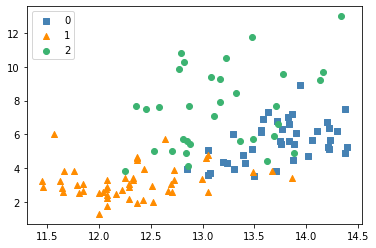

              precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.68      0.71      0.70        21
           2       0.67      0.40      0.50        15

    accuracy                           0.70        54
   macro avg       0.70      0.69      0.68        54
weighted avg       0.70      0.70      0.69        54



In [128]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(X_train, y_train)

# vamos observar cada uma das classes usando duas features..
plot_2d_space(X_train, y_train, feature_0, feature_1)

print(classification_report(y_test, classifier.predict(X_test)))

Agora, vamos ver o resultado com o ENN.

Aqui temos alguns hiperparâmetros para controlar:

- _n_neighbors_: tamanho da vizinhança
- _sampling_strategy_: escolha das classes que serão removidas, pode assumir o valor de lista para as classes da lista serem removidas, ou um dos seguintes:
    * _"majority"_: remove apenas da classe majoritaria
    * _"not majority"_: remove de todas as classes menos da majoritaria
    * _"not minority"_: remove de todas as classes menos da minoritaria
    * _"all"_: remove de todas as classes
    * _"auto"_: equivalente à _"not minority"_
- _kind_sel_: estratégia usada para remoção:
    * _"all"_: todos os vizinhos terão que concordar com as amostras de interesse para não serem excluídos
    * _"mode"_: utiliza voto majoritário para excluir uma amostra

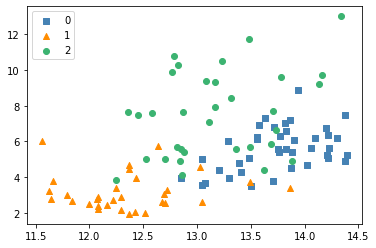

In [118]:
from imblearn.under_sampling import EditedNearestNeighbours

resampler = EditedNearestNeighbours(n_neighbors=5, sampling_strategy="auto", kind_sel="mode")
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)

# e as classes filtradas usando ENN
plot_2d_space(X_train_resampled, y_train_resampled, feature_0, feature_1)

Aqui percebemos que várias amostras das classes majoritárias próximas da região de separação foram removidas. Como amostras da classe minoritária não foram removidas (classe 2). Portanto, como está mais fácil classificar essa classe específica, devemos observar uma melhora na classificação.

In [129]:
model = KNeighborsClassifier(n_neighbors=7)

model.fit(X_train_resampled, y_train_resampled)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.88      0.67      0.76        21
           2       0.59      0.67      0.62        15

    accuracy                           0.74        54
   macro avg       0.74      0.74      0.73        54
weighted avg       0.76      0.74      0.74        54



Obtivemos uma melhora na classificação das classes 1 e 2.

## Instance Hardness Threshold

Esse algoritmo remove instâncias que sejam dificeis de serem classificadas. Para medir a dificuldade de classificação de uma instância, é utilizado um classificador para nos auxiliar. Esse classificador avalia a probabilidade daquela instãncia ser classificada, as instâncias com maior probabilidade de serem classificadas são mantidas, as instâncias com menor probabilidade são removidas.

Como hiperparâmetros, temos:

- _estimator_: o classificador utilizado para auferir a probabilidade de cada instância. Como padrão o _RandomForestClassifier_ é utilizado, e 'knn', 'decision-tree', 'random-forest', 'adaboost', 'gradient-boosting' and 'linear-svm' como opções.
- _sampling_strategy_: aqui temos uma variedade de possibilidades:
    * _float_: caso seja passado um _float_, o numero corresponde à razão do número de amostras da classe minoritária em relação à classe majoritária após reamostragem.
    * _str_: semelhante ao ENN.
    * _dict_: um dicionário corresponderá à quantidade de amostras por classe, no formato {_classe_: _numero_de_amostras_}

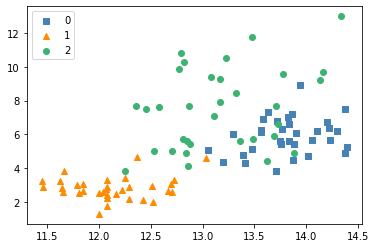

In [121]:
from imblearn.under_sampling import InstanceHardnessThreshold

resampler = InstanceHardnessThreshold(random_state=199)
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)

# e as classes filtradas usando ENN
plot_2d_space(X_train_resampled, y_train_resampled, feature_0, feature_1)

In [130]:
model = KNeighborsClassifier(n_neighbors=7)

model.fit(X_train_resampled, y_train_resampled)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.88      0.67      0.76        21
           2       0.59      0.67      0.62        15

    accuracy                           0.74        54
   macro avg       0.74      0.74      0.73        54
weighted avg       0.76      0.74      0.74        54



Observe que apesar de uma região completamente diferente no treinamento do _kNN_, o resultado no teste se manteve.